In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries
from functions import *

#### Load data

In [2]:
df_train = pd.read_parquet("/Users/solalzana/Desktop/X/Python for Data Science/Final Project/bike_counters/data/train.parquet")
df_test_kaggle = pd.read_parquet("/Users/solalzana/Desktop/X/Python for Data Science/Final Project/bike_counters/data/final_test.parquet")
df_ext = pd.read_csv("/Users/solalzana/Desktop/X/Python for Data Science/Final Project/bike_counters/data/external_data.csv")

#### Prepare data

In [3]:
df_train_cleaned = prepare_data(df_train, df_ext)
df_test_kaggle_cleaned = prepare_data(df_test_kaggle, df_ext)

#### Train/test split

In [4]:
# Splitting the data
X_train = df_train_cleaned.drop(columns=["log_bike_count", "bike_count"])
y_train = df_train_cleaned['log_bike_count']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_test_kaggle = df_test_kaggle_cleaned # when testing on kaggle

If testing on kaggle then use provided test dataset instead of splitting.

#### Build Pipeline

Different models to be tested here:

Train & evaluate models, and find the best one.


In [5]:
models = {
    # 'random_forest': RandomForestRegressor(
    #     n_estimators=100,
    #     random_state=42
    # ),
    
    'ridge': Ridge(
        random_state=42
    ),

    'xgboost': xgb.XGBRegressor(
        n_estimators=100,
        random_state=42,
        enable_categorical=True  # Add this if you have categorical features
    ),

    'catboost': CatBoostRegressor(
        iterations=100,
        random_state=42,
        verbose=False
    ),

    'lightgbm': LGBMRegressor(
        n_estimators=100,
        random_state=42
    )

}


Training ridge...


/Users/solalzana/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.85522e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


ridge RMSE: 0.9372631510705802

Training xgboost...
xgboost RMSE: 0.4435304579275182

Training catboost...
catboost RMSE: 0.4570814364821882

Training lightgbm...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 397461, number of used features: 123
[LightGBM] [Info] Start training from score 3.078263
lightgbm RMSE: 0.48513125010511937

Best model: xgboost with RMSE: 0.4435304579275182
Submission file created, check data folder


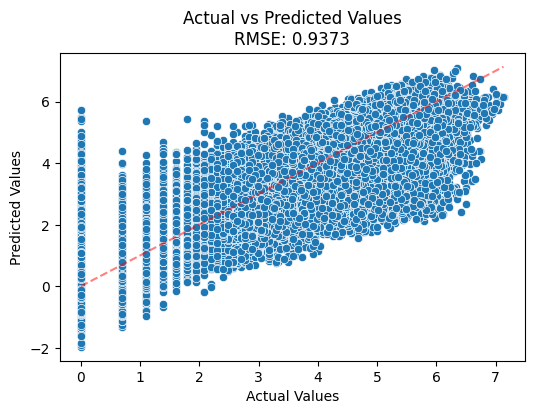

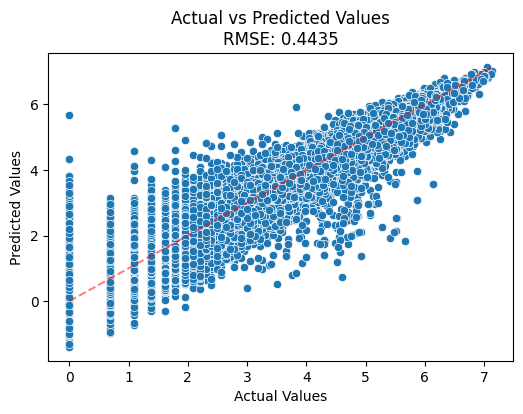

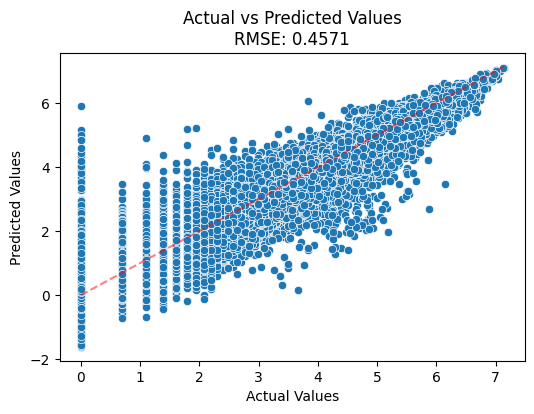

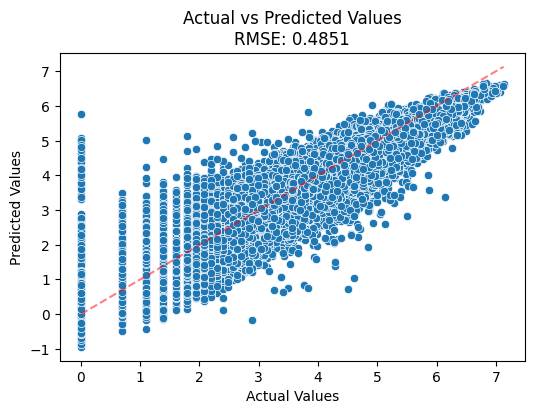

In [6]:
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline, rmse = train_and_evaluate_model(X_train, X_test, y_train, y_test, model)
    results[name] = {
        'pipeline': pipeline,
        'rmse': rmse
    }
    print(f"{name} RMSE: {rmse}")

best_model = min(results.items(), key=lambda x: x[1]['rmse'])
print(f"\nBest model: {best_model[0]} with RMSE: {best_model[1]['rmse']}")

test_model_kaggle(best_model[1]['pipeline'], X_test_kaggle, best_model[0])

In [7]:
test_model_kaggle(results[best_model[0]]['pipeline'], X_test_kaggle, best_model[0])

Submission file created, check data folder


####  Tune Hyperparameters

In [8]:
best_model_tuned = tune_hyperparameters(results[best_model[0]]['pipeline'], X_train, y_train).best_estimator_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/solalzana/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#### Submit predictions using the best model on Kaggle

In [9]:
best_pipeline = best_model[1]['pipeline']
test_model_kaggle(best_model_tuned, X_test_kaggle, best_model[0])

Submission file created, check data folder
